In [1]:
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("default")


Matplotlib is building the font cache; this may take a moment.


Data loaded from MongoDB Feature Store for EDA.

In [3]:
#Load Data from MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["Pearls_aqi_feature_store"]
col = db["karachi_air_qualityIndex"]

df = pd.DataFrame(list(col.find({}, {"_id": 0})))

df["timestamp"] = pd.to_datetime(
    df["timestamp"],
    format="mixed",
    dayfirst=True,
    errors="coerce"
)

print("Shape:", df.shape)
df.head()


Shape: (3384, 33)


,timestamp,pm25,pm10,co,no2,so2,o3,location,hour,day,...,pm10_lag_1h,pm10_lag_3h,pm25_rolling_3h,pm25_rolling_6h,pm25_rolling_12h,pm10_rolling_3h,pm10_rolling_6h,post_rain_effect,pm25_next_hour,pm10_next_hour
0,2025-09-01 11:00:00,23.9,56.7,244.0,5.7,12.0,72.0,Karachi,11,1,...,58.9,65.0,24.400000,24.816667,23.183333,58.866667,62.233333,0,25.8,62.6
1,2025-09-01 12:00:00,25.8,62.6,260.0,7.8,12.8,66.0,Karachi,12,1,...,56.7,61.0,24.700000,24.966667,23.783333,59.400000,61.533333,0,24.5,56.8
2,2025-09-01 13:00:00,24.5,56.8,271.0,12.6,12.6,57.0,Karachi,13,1,...,62.6,58.9,24.733333,24.866667,24.208333,58.700000,60.166667,0,24.3,49.2
3,2025-09-01 14:00:00,24.3,49.2,278.0,19.2,12.2,45.0,Karachi,14,1,...,56.8,56.7,24.866667,24.633333,24.475000,56.200000,57.533333,0,25.0,49.2
4,2025-09-01 15:00:00,25.0,49.2,282.0,23.6,11.7,37.0,Karachi,15,1,...,49.2,62.6,24.600000,24.650000,24.675000,51.733333,55.566667,0,25.2,49.6


PM2.5 shows strong temporal variation with peaks indicating pollution events.

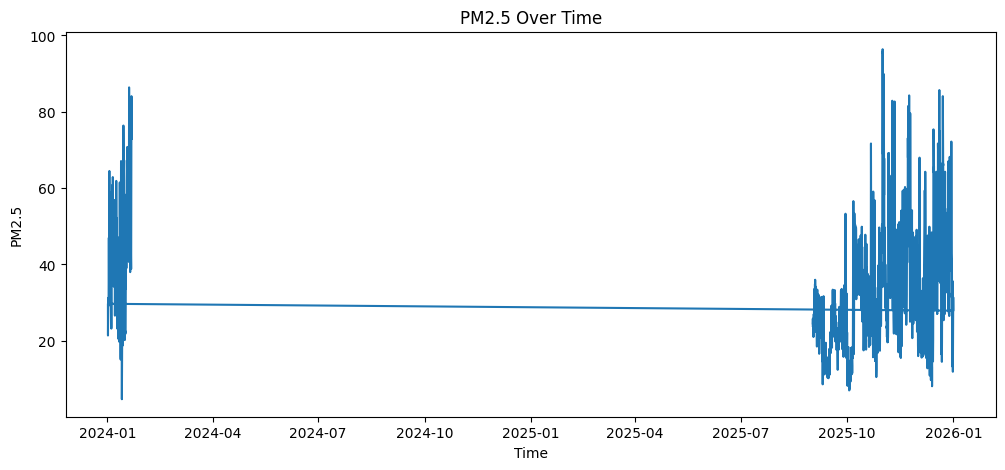

In [4]:
#PM2.5 Trend Over Time
plt.figure(figsize=(12,5))
plt.plot(df["timestamp"], df["pm25"])
plt.title("PM2.5 Over Time")
plt.xlabel("Time")
plt.ylabel("PM2.5")
plt.show()

Winter months show higher PM2.5 levels due to weather and emissions.

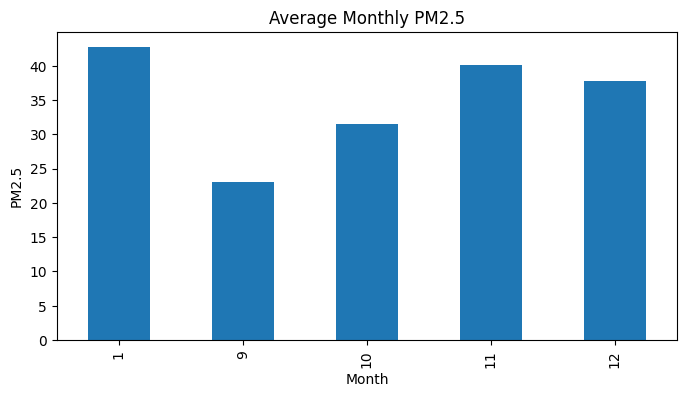

In [5]:
#Monthly / Seasonal Trend
df["month"] = df["timestamp"].dt.month

df.groupby("month")["pm25"].mean().plot(
    kind="bar",
    figsize=(8,4),
    title="Average Monthly PM2.5"
)
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

Higher PM2.5 during rush hours reflects traffic emissions.

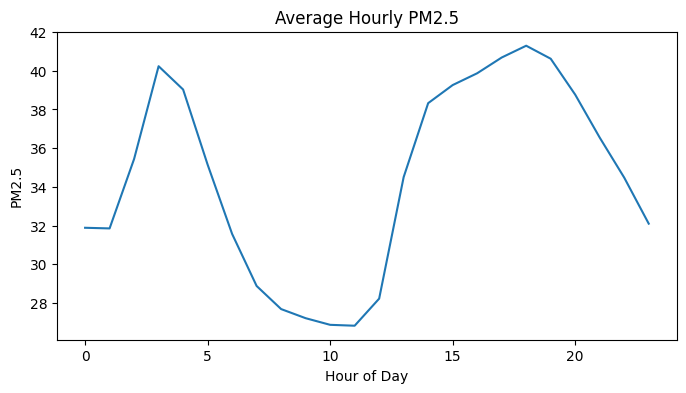

In [6]:
#Hourly (Daily Pattern)
df.groupby("hour")["pm25"].mean().plot(
    figsize=(8,4),
    title="Average Hourly PM2.5"
)
plt.xlabel("Hour of Day")
plt.ylabel("PM2.5")
plt.show()

Weekdays exhibit higher pollution due to increased human activity.

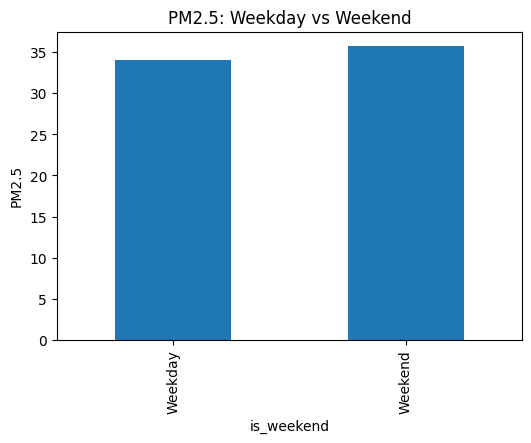

In [7]:
#Weekday vs Weekend
df.groupby("is_weekend")["pm25"].mean().plot(
    kind="bar",
    figsize=(6,4)
)
plt.xticks([0,1], ["Weekday", "Weekend"])
plt.title("PM2.5: Weekday vs Weekend")
plt.ylabel("PM2.5")
plt.show()

PM2.5 and PM10 are strongly correlated, indicating common emission sources.

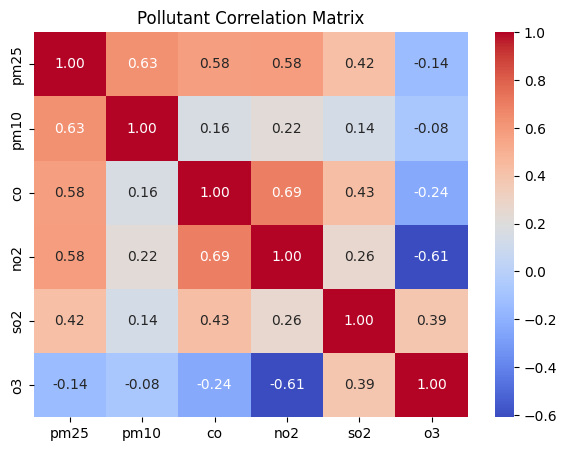

In [8]:
#Correlation Analysis
pollutants = ["pm25", "pm10", "co", "no2", "so2", "o3"]

corr = df[pollutants].corr()

plt.figure(figsize=(7,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pollutant Correlation Matrix")
plt.show()

Strong autocorrelation confirms suitability of time-series models.

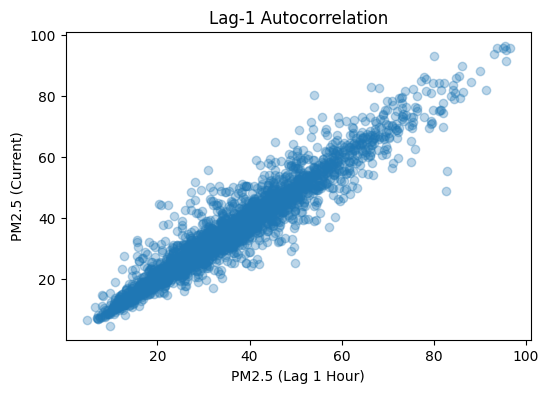

In [9]:
#Lag Feature Importance (Autocorrelation)
plt.figure(figsize=(6,4))
plt.scatter(df["pm25_lag_1h"], df["pm25"], alpha=0.3)
plt.xlabel("PM2.5 (Lag 1 Hour)")
plt.ylabel("PM2.5 (Current)")
plt.title("Lag-1 Autocorrelation")
plt.show()

Long-tailed distribution highlights hazardous AQI events.

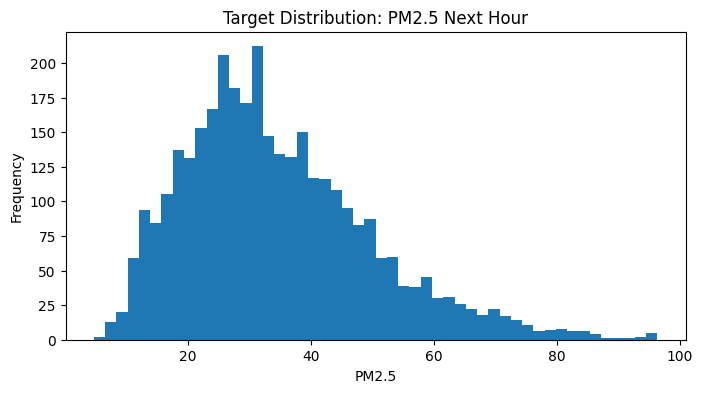

In [10]:
#Target Distribution
plt.figure(figsize=(8,4))
plt.hist(df["pm25_next_hour"], bins=50)
plt.title("Target Distribution: PM2.5 Next Hour")
plt.xlabel("PM2.5")
plt.ylabel("Frequency")
plt.show()

### EDA Summary

- PM2.5 levels peak during winter months and rush hours.
- Strong temporal autocorrelation exists in pollutant levels.
- Lag and rolling features are highly informative for forecasting.
- Pollution is significantly higher on weekdays.
- Extreme AQI events are rare but impactful.

These insights justify the use of tree-based and time-aware models.